# pyTorch를 이용하여 CIFAR10 이미지 분류

pyTorch를 이용하여 Convolutional Neural Networks를 구현하고 훈련하여 CIFAR10 데이터셋을 분류하는 모델을 만든다.

## Step 1. 모듈 임포트

* os: 시스템 프로그래밍을 위해(본 예제에서는 경로 설정을 위해 사용함)
* numpy: 기본적인 행렬연산
* matplotlib: 그래프 플로팅
* torch, torchvision: 파이토치 모듈
* torchvision.transforms: 데이터 전처리 모듈
* torchvision.datasets: 데이터셋 모듈(CIFAR 로드)
* torch.nn: 신경망 구현에 필요한 모듈
* torch.nn.functional: 신경망에 쓰이는 함수를 포함하는 모듈
* torch.optim: optimizer 모듈

In [1]:
import os

# 기본적인 연산 및 플로팅에 필요한 모듈
import numpy as np
import matplotlib.pyplot as plt

# torch 모듈
import torch
import torchvision
# 데이터셋 관련 모듈
import torchvision.transforms as transforms
import torchvision.datasets as dset

# neural network 모듈
import torch.nn as nn
import torch.nn.functional as F

# optimizer 모듈
import torch.optim as optim

## Step2: CIFAR10 데이터셋 불러오기

### GPU사용과 미니배치

* use_gpu: GPU를 쓸수 있는지에 대한 여부 확인
* mini_batch_size: 한번에 훈련시킬 미니배치 수

### transforms.Compose()

데이터를 전처리할 수 있는 시스템.

* ToTensor(): numpy.array 또는 PIL 이미지 데이터형을 pytorch.Tensor로 변환
* transforms.Normalize((mean),(std)): 데이터 정규화

### torchvision.datasets

자주 쓰이는 데이터셋을 편하게 가져올 수 있는 모듈. 만약 사용자 임의의 데이터셋을 가져오고 싶으면 dataset class를 따로 형식에 맞게 정의하여 사용한다.(추후에 설명할 예정)

* root: 데이터를 저장할 위치
* train: True일 시 train set 로드, False일 시 test set 로드
* download: 데이터를 웹에서 다운로드 할 지 여부, 이미 원본파일을 넣어놓은 상태면 False로 설정.
* tranform: 사용할 전처리 시스템

### torch.utils.data.DataLoader

가져온 데이터셋을 편하게 쓸 수 있는 iterator개념의 데이터형

* dataset: 가져올 데이터셋
* batch_size: 한번에 훈련시킬 미니배치 크기
* shuffle: 데이터셋을 섞을것인지 여부
* num_workers: 데이터를 가져올 때 사용할 sub-process갯수(일반적으로 코어 갯수만큼 할당)
* pin_memory: 데이터를 페이지 테이블에 할당할 지에 대한 여부(GPU사용시 쓰는게 좋음)

In [3]:
use_GPU = torch.cuda.is_available()
mini_batch_size = 128

# import torchvision.transforms as transforms
# import torchvision.datasets as dset

transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

trainset = dset.CIFAR10(root='./data', train=True,
                        download=False, transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=mini_batch_size,
                                          shuffle=True,
                                          num_workers=2,
                                          pin_memory=False)

testset = dset.CIFAR10(root='./data', train=False,
                       download=False, transform=transforms)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=mini_batch_size,
                                         shuffle=False,
                                         num_workers=2,
                                         pin_memory=False
                                        )

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

In [4]:
print(trainset)
print(testset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


## 데이터 시각화

데이터의 원본은 PIL이미지 형태임. iter함수를 이용하여 training set의 데이터를 랜덤으로 가져와서 특정 몇 장을 출력하도록 함

### imshow_CIFAR() 함수

데이터셋의 내용(사진)을 출력해주는 함수. 데이터셋의 정규화를 해제하고 파이토치 Tensor를 numpy array로 바꾼 후 matplotlib을 이용하여 사진을 출력해준다.

### iter()

객체에 내장된 \_\_iter\_\_() 메소드를 호출해준다. DataLoader()의 이터레이터는 데이터를 순회하며 mini batch 사이즈의 data와 label을 꺼내 온다.(img.size(), label.size() 참고) 

In [5]:
def imshow_CIFAR(img):
    img = img*0.5 + 0.5 # normalize 해제
    img_np = img.numpy() # numpy배열로 변경
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(np.transpose(img_np, (1, 2, 0)))
    # 형태를 배치 x 가로 x 세로 => 가로 x 세로 x 배치 형태로 전환
    plt.show

In [6]:
# 무작위로 training data의 한 배치를 가져옴
data_iter = iter(trainloader)
img, label = data_iter.next()

print(img.size())
print(label.size())

torch.Size([128, 3, 32, 32])
torch.Size([128])


dog bird plane deer truck


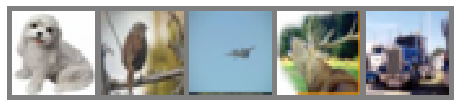

In [8]:
# 샘플 이미지 5장 출력
img = img[0:5, :, :, :]
imshow_CIFAR(torchvision.utils.make_grid(img))
disp_label = f'{classes[label[0]]} {classes[label[1]]} {classes[label[2]]} \
{classes[label[3]]} {classes[label[4]]}'
print(disp_label)

## Step3: Convolutional Neural Networks 정의

### 3채널 이미지 처리

input_channel을 3으로 주고 RGB이미지를 처리할 수 있도록 한다.

#### 예제에서 나온 인공신경망(약 60%정도 정확도)

* input image size: 3 x 32 x 32
* conv층 1: kernel size: 5, kernel depth: 6 => 6 x 28 x 28
* max_pool층 1: kernel size: 2, stride: 2 => 6 x 14 x 14
* conv층 2: kernel size: 5, kernel depth: 16 => 16 x 10 x 10
* max_pool층 2: kernel size: 2, stride: 2 => 16 x 5 x 5
* fc층 1: input size: 16 * 5 * 5, output size: 120
* fc층 2: input size: 120, output size: 84
* fc층 3: input size: 84, output size: 10(!!class 수와 동일해야함)

#### 개선한 인공신경망

신경망을 더 깊게 하고 각 층 사이에 batch normalization 층을 추가함

* input image size: 3 x 32 x 32
* conv1: K=7, padding=3, out_channel=24 => 24 x 32 x 32
* conv2: K=7, padding=3, out_channel=48 => 48 x 32 x 32
* max_pool1: K=2, stride=2 => 48 x 16 x 16
* conv3: K=7, padding=3, out_channel=96 => 96 x 16 x 16
* conv4: K=7, padding=3, out_channel=192 => 192 x 16 x 16
* conv5: K=7, padding=3, out_channel=256 => 256 x 16 x 16
* max_pool2: K=2, stride=2 => 64 x 8 x 8
* conv6: K=5, padding=2, out_channel=480 => 480 x 8 x 8
* conv7: K=5, padding=2, out_channel=512 => 512 x 8 x 8
* fc1: output=1024
* fc2: output=512
* fc3: output=256
* fc4: output=64
* fc5: output=10

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 24, 7, padding=3)
        self.bnorm1 = nn.BatchNorm2d(24)
        self.conv2 = nn.Conv2d(24, 48, 7, padding=3)
        self.bnorm2 = nn.BatchNorm2d(48)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(48, 96, 7, padding=3)
        self.bnorm3 = nn.BatchNorm2d(96)
        self.conv4 = nn.Conv2d(96, 192, 7, padding=3)
        self.bnorm4 = nn.BatchNorm2d(192)
        self.conv5 = nn.Conv2d(192, 256, 7, padding=3)
        self.bnorm5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 480, 5, padding=2)
        self.bnorm6 = nn.BatchNorm2d(480)
        self.conv7 = nn.Conv2d(480, 512, 5, padding=2)
        self.bnorm7 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(512*8*8, 1024)
        self.bnorm8 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bnorm9 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.bnorm10 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 64)
        self.bnorm11 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bnorm1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bnorm2(x)
        x = F.relu(self.conv3(x))
        x = self.bnorm3(x)
        x = F.relu(self.conv4(x))
        x = self.bnorm4(x)
        x = self.pool(F.relu(self.conv5(x)))
        x = self.bnorm5(x)
        x = F.relu(self.conv6(x))
        x = self.bnorm6(x)
        x = F.relu(self.conv7(x))
        x = self.bnorm7(x)
        x = x.view(-1, 512*8*8)
        x = F.relu(self.fc1(x))
        x = self.bnorm8(x)
        x = F.relu(self.fc2(x))
        x = self.bnorm9(x)
        x = F.relu(self.fc3(x))
        x = self.bnorm10(x)
        x = F.relu(self.fc4(x))
        x = self.bnorm11(x)
        x = self.fc5(x)
        return x

## Step 4. 모델 생성, 출력층 함수 정의, optimizer 정의

### 모델 생성

step 3에서 정의한 모델을 생성한다. GPU를 이용하는 경우 .cuda()메소드를 통해 모델을 바꿔줘야 한다.

* torch.cuda.is_available()을 통해 cuda가 사용 가능한지 확인한다.

### 출력층 함수

일반적으로 회귀 문제의 경우 항등 함수(identity funciton)을 출력층 함수로 사용한다. 이진 분류(binary classification)의 경우 BCELoss를 출력층 함수로 사용한다. 다중 분류 문제의 경우 softmax function을 출력층 함수로 사용하고, cross entrophy function을 loss function으로 사용한다. CIFAR-10은 다중 분류 문제이기 때문에 softmax - cross entrophy loss function을 사용한다.

### optimizer

가장 최근에 나온 optimizer인 Adam optimizer를 사용한다.

사용할 수 있는 최적화 기법 예시(Docs를 참고하면 더 심화된 최적화 기법도 사용가능)

* SGD
* Momentum
* Nesterov Momentum
* Adagrad
* Adam
* RMSprop

In [18]:
model = Net()

if use_GPU:
    model = model.cuda()
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## Step 5. 신경망 훈련

생성한 신경망을 훈련한다. 각 epoch마다 test loss 및 training loss를 기록하고 모델을 저장한다.

* GPU사용: model, input data, label을 .cuda()메소드를 이용하여 변환해줘야 GPU를 사용하여 연산을 진행함.
* optimizer.zero_grad(): 훈련 시작 이전에 전에 계산한 그래디언트를 초기화시켜야 함
* loss.backward(): 역전파 알고리즘 실행
* optimizer.step(): 그래디언트 갱신
* torch.save(): 모델 저장

### 모델 저장

만약 각 epoch에 해당하는 모델을 저장해 놓고 최적의 모델을 찾아서 쓰고 싶은 경우 torch.save()를 이용한다. torch.save()의 결과는 사용자가 지정한 디렉터리 내부에 저장된다.

In [9]:
from math import ceil

epochs_num = 10
epochs_per_iter_train = ceil(50000 / mini_batch_size)
epochs_per_iter_test = ceil(10000 / mini_batch_size)

In [19]:
for epoch in range(epochs_num):
    
    running_loss_train = 0.0
    running_loss_test = 0.0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        if use_GPU:
            inputs, labels = inputs.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()
        
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        if use_GPU:
            inputs, labels = inputs.cuda(), labels.cuda()
        
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        running_loss_test += loss.item()
        
    torch.save(model.state_dict(), os.path.join('./model', 'epoch-{}.pt'.format(epoch)))
    running_loss_train_avg = running_loss_train / epochs_per_iter_train
    running_loss_test_avg = running_loss_test / epochs_per_iter_test
    outstr = f'epochs {epoch+1}: tr_loss={running_loss_train_avg}, test_loss={running_loss_test_avg}'
    print(outstr)

print('Finished Training')

epochs 1: tr_loss=1.486105594482422, test_loss=1.189016146850586
epochs 2: tr_loss=1.0144872616577147, test_loss=0.917370637512207
epochs 3: tr_loss=0.7896917605590821, test_loss=0.7719600685119629
epochs 4: tr_loss=0.6473466975402832, test_loss=0.6730734130859375
epochs 5: tr_loss=0.5347230210113525, test_loss=0.6270055213928223
epochs 6: tr_loss=0.44726434158325196, test_loss=0.6180935024261475
epochs 7: tr_loss=0.3617545763778687, test_loss=0.6059476890563965
epochs 8: tr_loss=0.2931663357925415, test_loss=0.595866215133667
epochs 9: tr_loss=0.2448773399734497, test_loss=0.6218734779357911
epochs 10: tr_loss=0.19251313181877136, test_loss=0.6427758514404297
Finished Training


In [117]:
dataiter = iter(testloader)
img, labels = dataiter.next()

ground truth: frog cat car plane


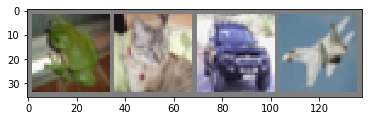

In [118]:
img = img[7:11, :,:,:]
labels = labels[7:11]

imshow_CIFAR(torchvision.utils.make_grid(img))
outstr = f'ground truth: {classes[labels[0]]} {classes[labels[1]]} {classes[labels[2]]} {classes[labels[3]]}'
print(outstr)

In [119]:
img = img.cuda()
outputs = model(img)
_, pred = torch.max(outputs, 1)
outstr = f'estimate: {classes[pred[0]]} {classes[pred[1]]} {classes[pred[2]]} {classes[pred[3]]}'
print(outstr)

estimate: frog cat truck plane


## Step 6. 정확도 측정

최종 test accuracy를 측정한다.

### Model 불러오기

torch.save로 저장한 model은 model 자체가 아니라 모델 내부의 파라미터를 저장하는 구조체이다. 모델을 완전히 불러오기 위해 먼저 model을 정의하고 정의한 모델의 파라미터를 torch.save에서 저장한 파일에 있는 파라미터로 바꾼다.

### evaluation mode

훈련 이후에 모델을 평가할 때는 model.eval()을 이용하여 모델의 옵션을 바꿔 줘야 한다. eval mode의 모델은 dropout, batch normalization 옵션이 비활성화된다.

### accuracy 평가

test set을 for문으로 순회하면서 정확도를 평가한다. 별도로 정확도를 바로 평가해주는 함수는 pyTorch에서 제공하지 않는다.

In [21]:
model_opt = Net()
model_opt.load_state_dict(torch.load('./model/epoch-7.pt'))
model_opt = model_opt.eval()

if use_GPU:
    model_opt = model_opt.cuda()

correct = 0
total = 0

for data in testloader:
    img, labels = data
    if use_GPU:
        img, labels = img.cuda(), labels.cuda()
        
    outputs = model_opt(img)
    _, pred = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()

outstr = f'test accuracy : {correct / total}'
print(outstr)

test accuracy : 0.8254
